# DataCo SMART SUPPLY CHAIN FOR BIG DATA ANALYSIS

In [75]:
#MACHINE LEARNING MODELS FOR SALES PREDICTION AND FRAUD DETECTION

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import datetime as dt
import calendar,warnings,itertools,matplotlib,keras,shutil
import tensorflow as tf
import statsmodels.api as sm
from datetime import datetime
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor,BaggingClassifier,ExtraTreesClassifier
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from sklearn.datasets import load_iris,make_regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_ridge import KernelRidge
from keras import Sequential
from keras.layers import Dense
from IPython.core import display as ICD
#from tensorflow_core.estimator import inputs

#Hiding the warnings
warnings.filterwarnings('ignore') 


In [77]:
dataset=pd.read_csv("DataCoSupplyChainDataset.csv",header= 0,encoding= 'unicode_escape')
dataset.head(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [78]:
dataset.shape

(180519, 53)

In [79]:
dataset.apply(lambda x: sum(x.isnull()))

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [80]:
# Adding first name and last name together to create new column
dataset['Customer Full Name'] = dataset['Customer Fname'].astype(str)+dataset['Customer Lname'].astype(str)

In [81]:
data=dataset.drop(['Customer Email','Product Status','Customer Password','Customer Street','Customer Fname','Customer Lname',
           'Latitude','Longitude','Product Description','Product Image','Order Zipcode','shipping date (DateOrders)'],axis=1)
data.shape

(180519, 42)

In [82]:
data['Customer Zipcode']=data['Customer Zipcode'].fillna(0)#Filling NaN columns with zero

<AxesSubplot:>

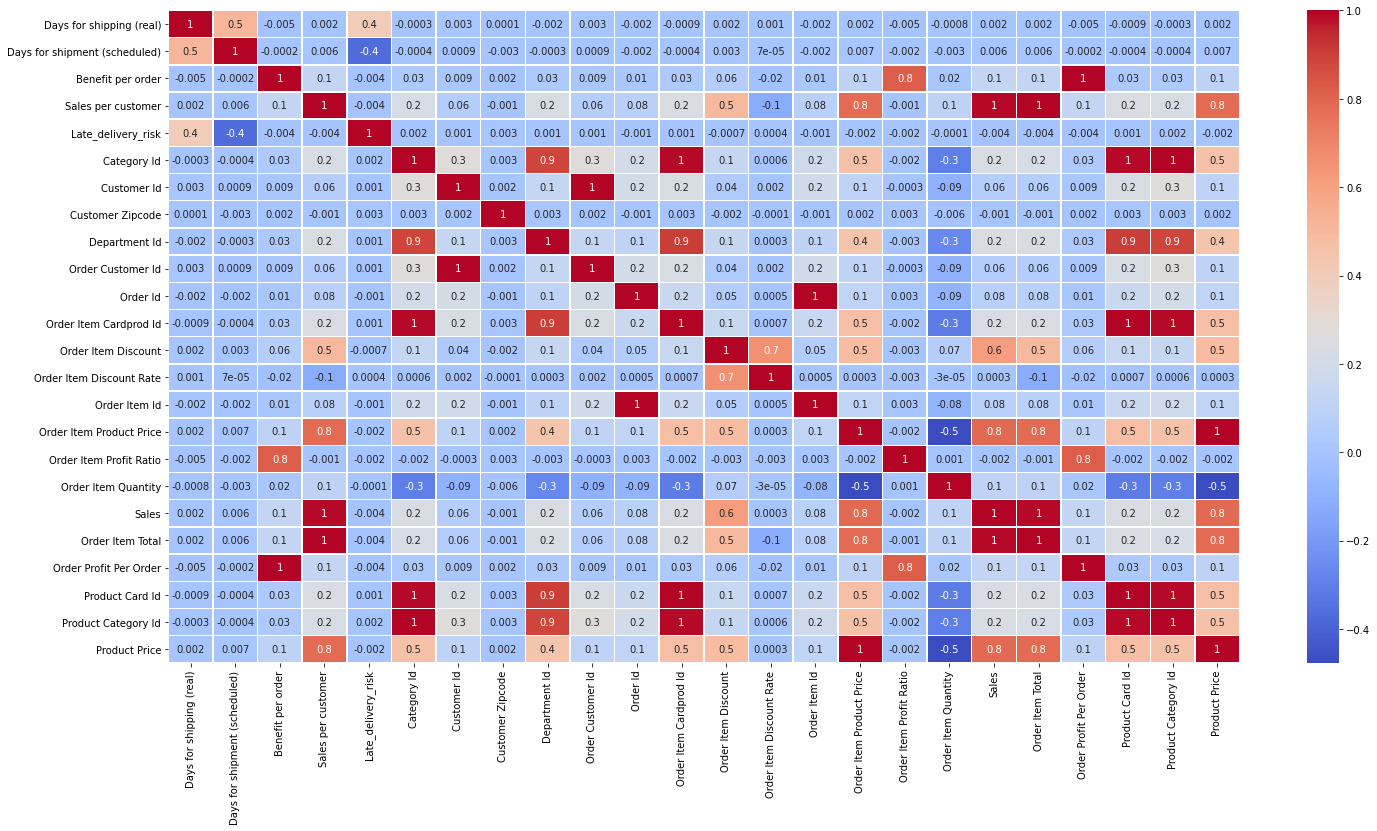

In [83]:
fig, ax = plt.subplots(figsize=(24,12))         # figsize
sns.heatmap(data.corr(),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm') # Heatmap for correlation matrix

<AxesSubplot:title={'center':'Total sales for all regions'}, xlabel='Order Region'>

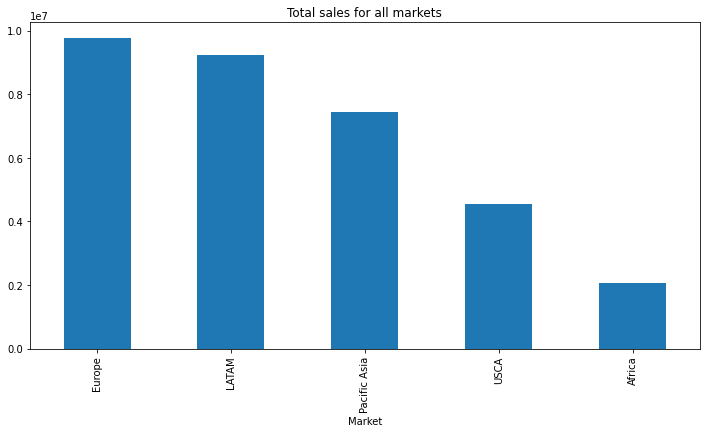

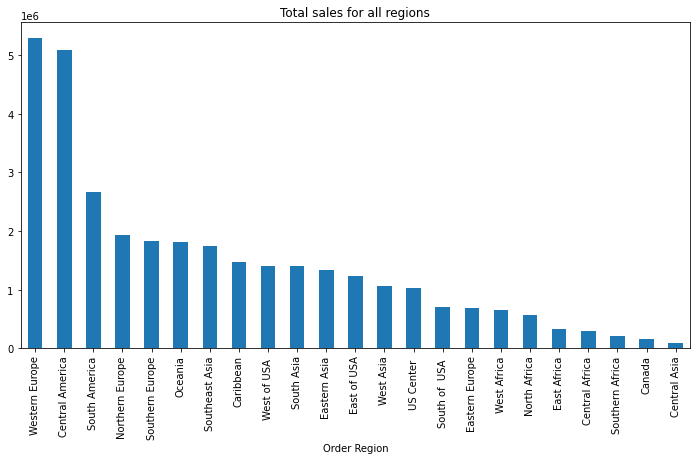

In [84]:
market = data.groupby('Market') #Grouping by market
region = data.groupby('Order Region')
plt.figure(1)
market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all markets")
plt.figure(2)
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all regions")

<AxesSubplot:title={'center':'Average price'}, xlabel='Category Name'>

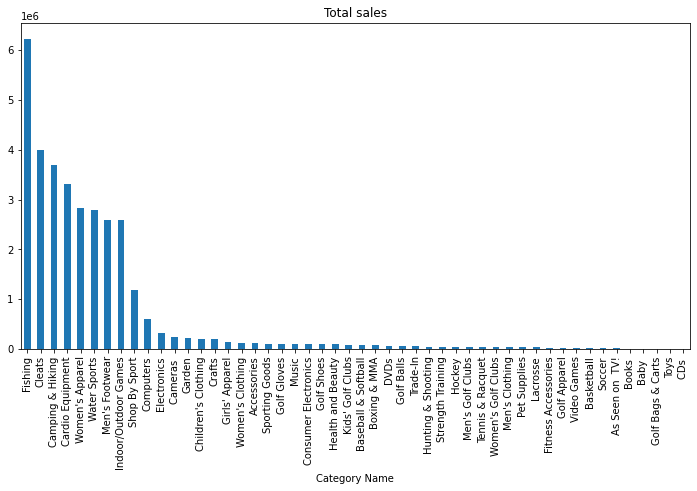

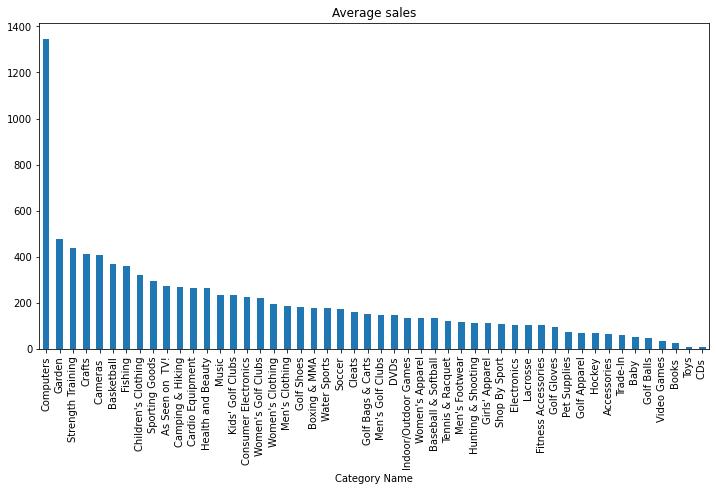

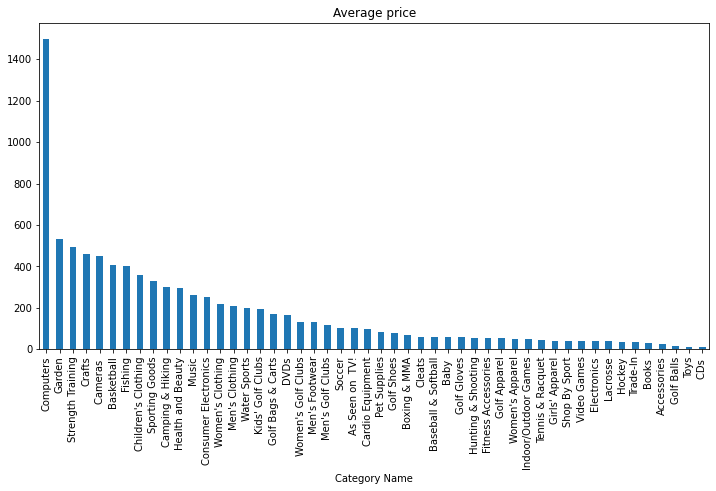

In [85]:
#Grouping all categories
cat = data.groupby('Category Name')
plt.figure(1)
# Total sum of sales for all categories
cat['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales")
# Mean sales for all categories
plt.figure(2)
cat['Sales per customer'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average sales")
plt.figure(3)
# Mean prices for all categories
cat['Product Price'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average price")

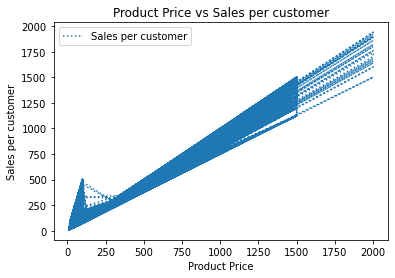

In [86]:
data.plot(x='Product Price', y='Sales per customer',linestyle='dotted',
     markerfacecolor='blue', markersize=12) 
plt.title('Product Price vs Sales per customer')#title
plt.xlabel('Product Price')  # X-axis title
plt.ylabel('Sales per customer') # Y=axis title
plt.show()

In [87]:
data['order_year']= pd.DatetimeIndex(data['order date (DateOrders)']).year
data['order_month'] = pd.DatetimeIndex(data['order date (DateOrders)']).month

data['order_hour'] = pd.DatetimeIndex(data['order date (DateOrders)']).hour
data['order_month_year'] = pd.to_datetime(data['order date (DateOrders)']).dt.to_period('M')

In [88]:
data['order_week_day'] = pd.DatetimeIndex(data['order date (DateOrders)']).day_name

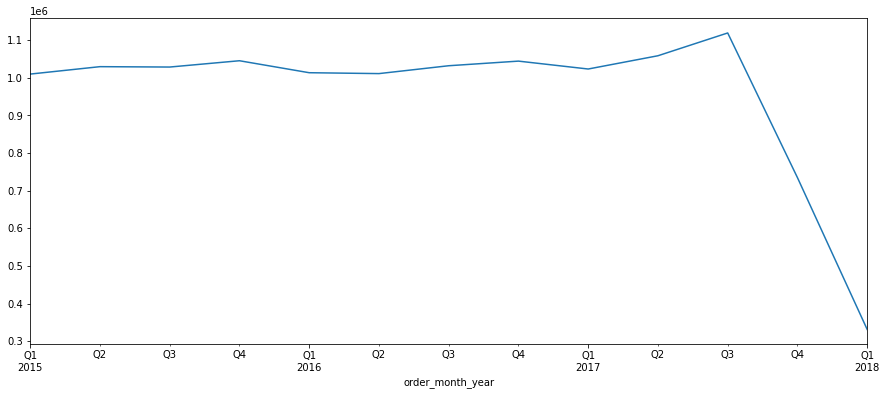

In [89]:
quater= data.groupby('order_month_year')
quartersales=quater['Sales'].sum().resample('Q').mean().plot(figsize=(15,6))

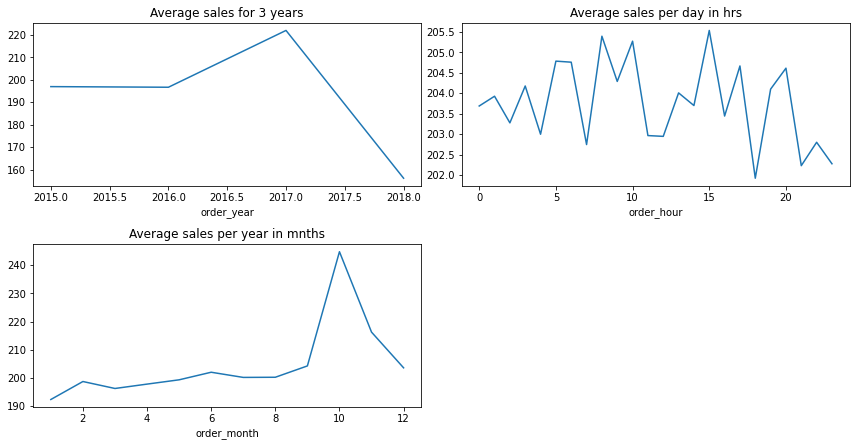

In [90]:
plt.figure(figsize=(10,12))
plt.subplot(4, 2, 1)
quater= data.groupby('order_year')
quater['Sales'].mean().plot(figsize=(12,12),title='Average sales for 3 years')
plt.subplot(4, 2, 2)

hrs=data.groupby("order_hour")
hrs['Sales'].mean().plot(figsize=(12,12),title='Average sales per day in hrs')
plt.subplot(4, 2, 3)
mnth=data.groupby("order_month")
mnth['Sales'].mean().plot(figsize=(12,12),title='Average sales per year in mnths')
plt.tight_layout()
plt.show()

In [91]:
data['Type'].unique()

array(['DEBIT', 'TRANSFER', 'CASH', 'PAYMENT'], dtype=object)

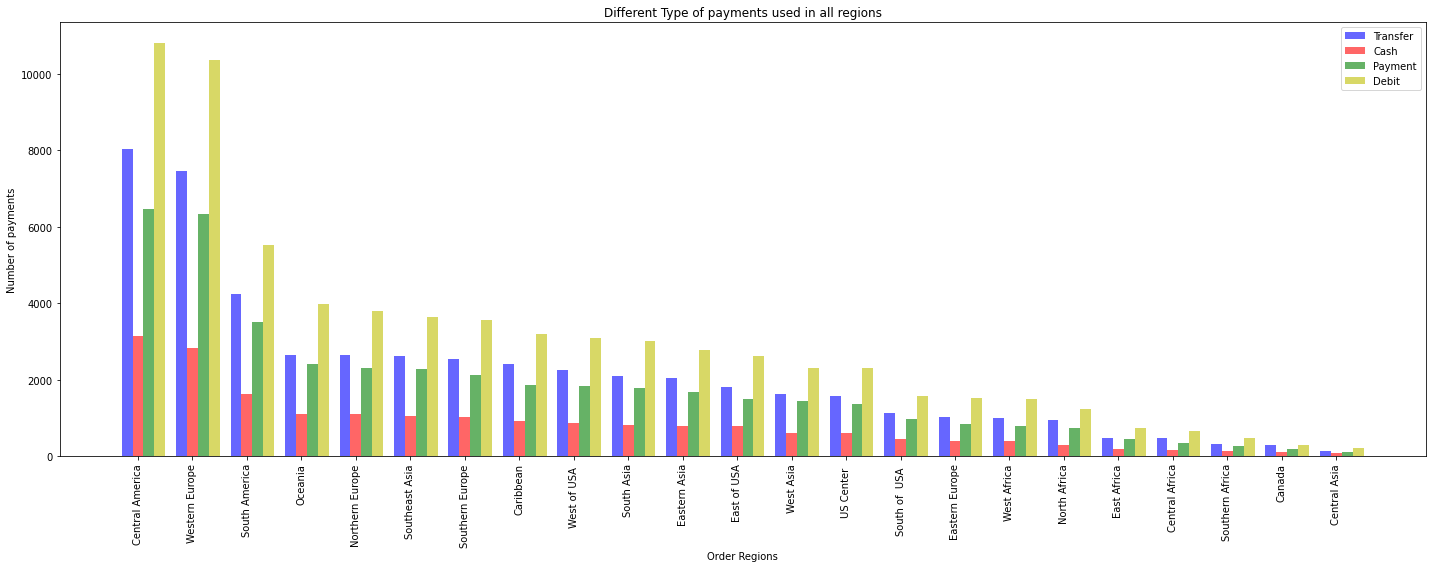

In [92]:
xyz1 = data[(data['Type'] == 'TRANSFER')]
xyz2= data[(data['Type'] == 'CASH')]
xyz3= data[(data['Type'] == 'PAYMENT')]
xyz4= data[(data['Type'] == 'DEBIT')]
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
count3=xyz3['Order Region'].value_counts()
count4=xyz4['Order Region'].value_counts()
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Transfer')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='Cash')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='Payment')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='Debit')
plt.xlabel('Order Regions')
plt.ylabel('Number of payments')
plt.title('Different Type of payments used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

Total revenue lost with orders -3883547.345768667


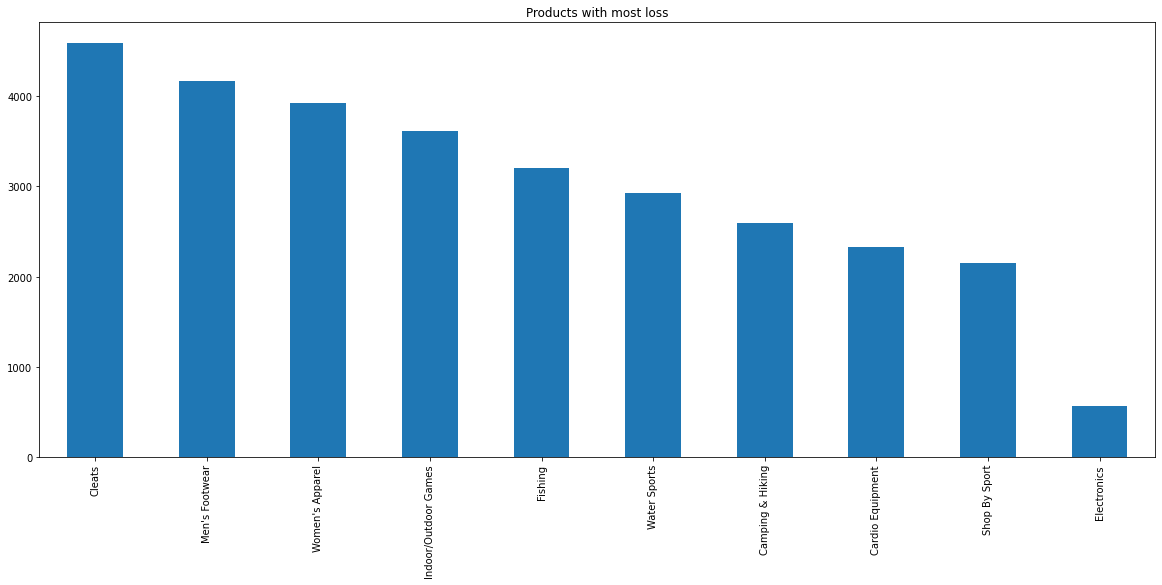

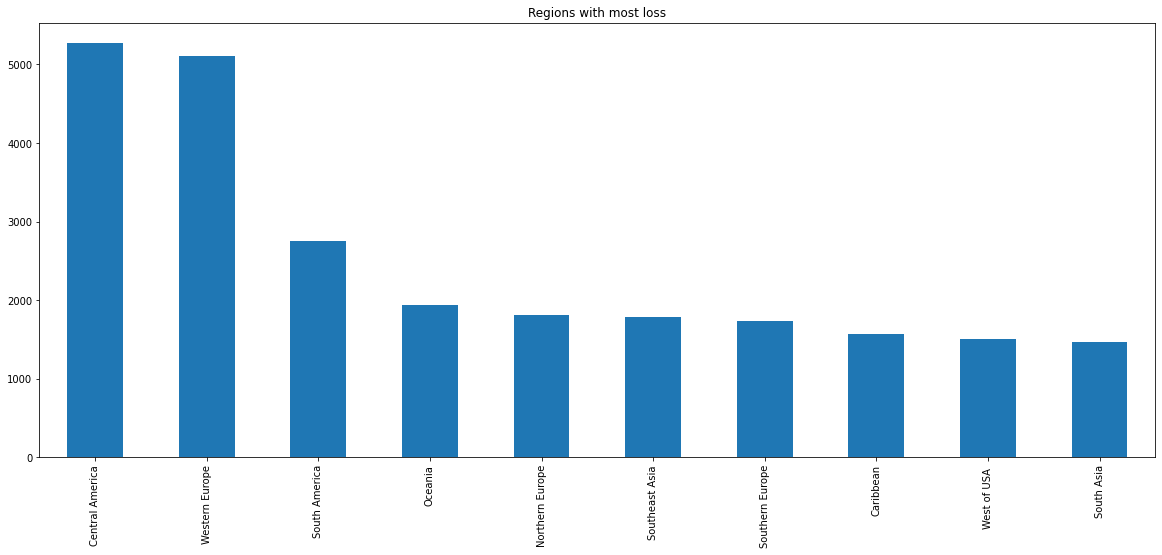

In [93]:
loss = data[(data['Benefit per order']<0)]
#Plotting top 10 products with most loss
plt.figure(1)
loss['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Products with most loss")
plt.figure(2)
loss['Order Region'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Regions with most loss")
#Sum of total sales which are lost
print('Total revenue lost with orders',loss['Benefit per order'].sum())

In [94]:
#Checking type of payment used to conduct fraud other than Transfer
xyz = data[(data['Type'] != 'TRANSFER')&(data['Order Status'] == 'SUSPECTED_FRAUD')]
xyz['Order Region'].value_counts()

Series([], Name: Order Region, dtype: int64)

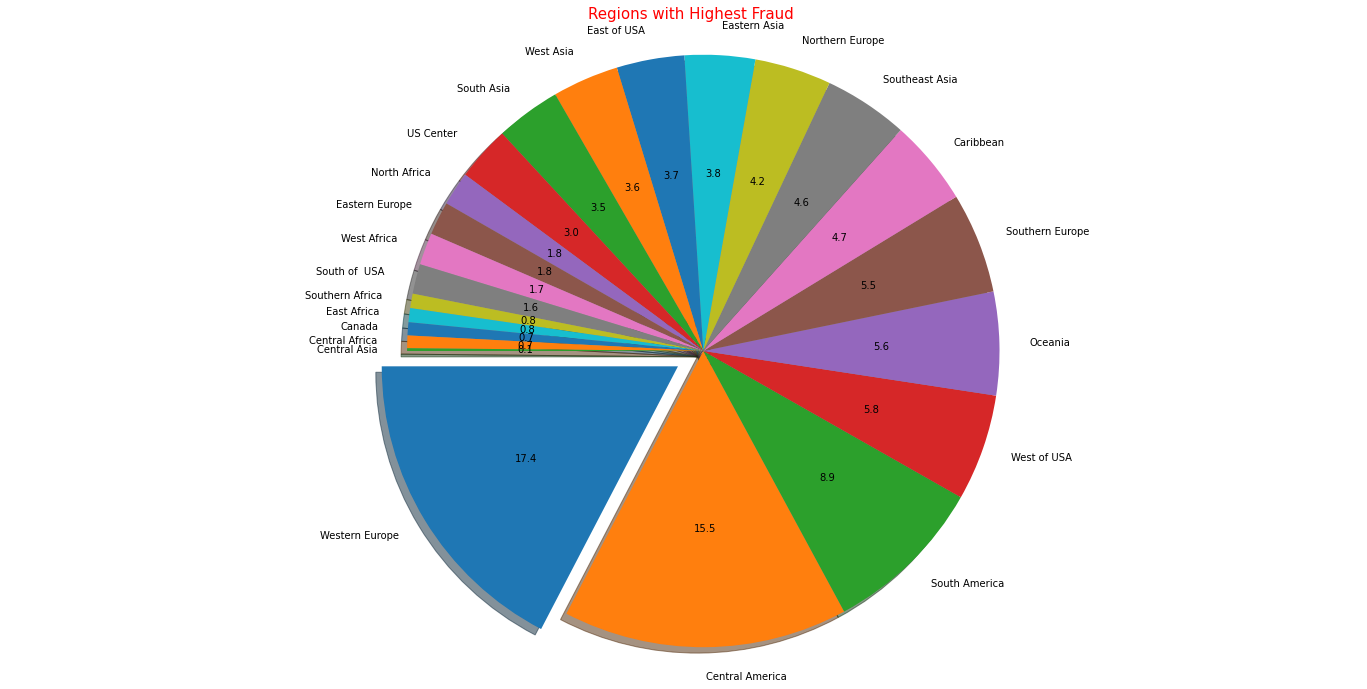

In [95]:
high_fraud = data[(data['Order Status'] == 'SUSPECTED_FRAUD') & (data['Type'] == 'TRANSFER')]#separating orders with suspected fraud
#Plotting pie chart with respect to order region
fraud=high_fraud['Order Region'].value_counts().plot.pie(figsize=(24,12),
                                                  startangle=180, explode=(0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),autopct='%.1f',shadow=True,)
plt.title("Regions with Highest Fraud",size=15,color='r') # Plotting title
plt.ylabel(" ")
fraud.axis('equal') 
plt.show()

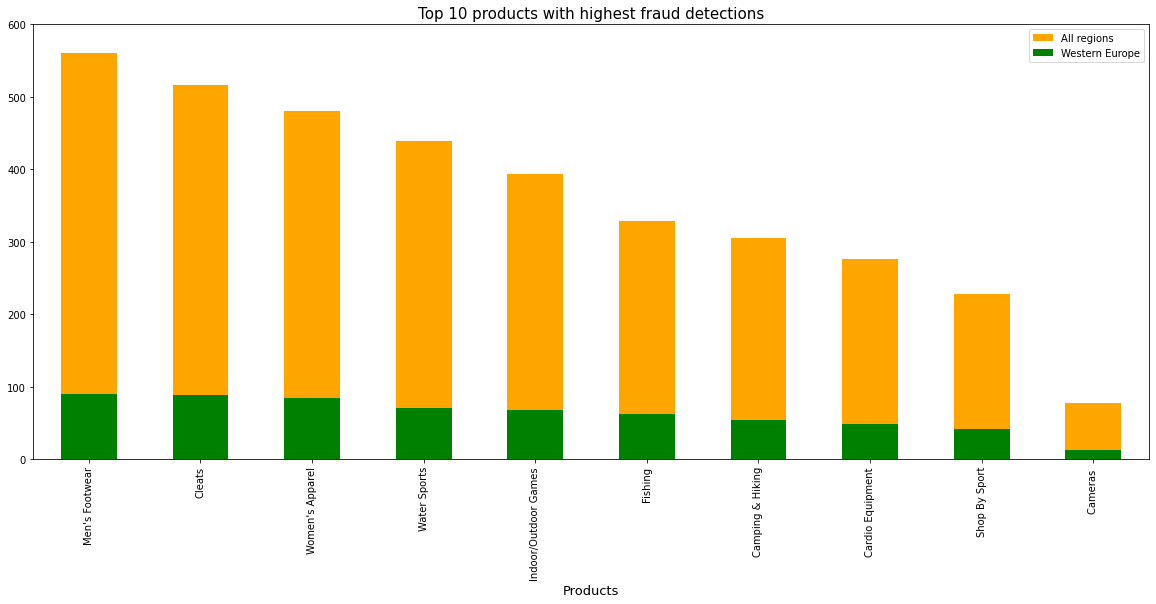

In [96]:
high_fraud1 = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] # 
high_fraud2 = data[(data['Order Status'] == 'SUSPECTED_FRAUD') &(data['Order Region'] == 'Western Europe')]
#Plotting bar chart for top 10 most suspected fraud department in all regions
fraud1=high_fraud1['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud Category",color='orange')
#Plotting bar chart for top 10 most suspected fraud department in Western Europe
fraud2=high_fraud2['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud product in Western Europe",color='green')
plt.legend(["All regions", "Western Europe"])
plt.title("Top 10 products with highest fraud detections", size=15)
plt.xlabel("Products", size=13)
plt.ylim(0,600)
plt.show()


<AxesSubplot:title={'center':'Top 10 Highest Fraud Customers'}>

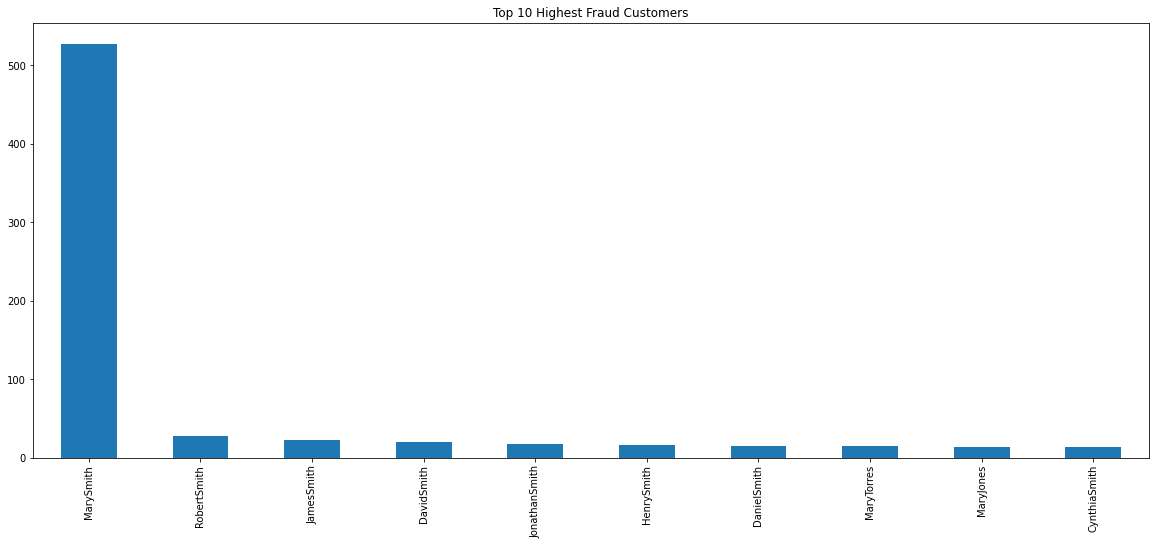

In [97]:
#Filtering out suspected fruad orders
cus = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] 
#Top 10 customers with most fraud
cus['Customer Full Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Top 10 Highest Fraud Customers")

In [98]:
#Filtering orders of mary smith with suspected fraud
amount = data[(data['Customer Full Name'] == 'MarySmith')&(data['Order Status'] == 'SUSPECTED_FRAUD')]
#Plotting bar chart for top 10 most suspected fraud customers
amount['Sales'].sum()

102491.66191043999

<AxesSubplot:title={'center':'Top 10 products with most late deliveries'}>

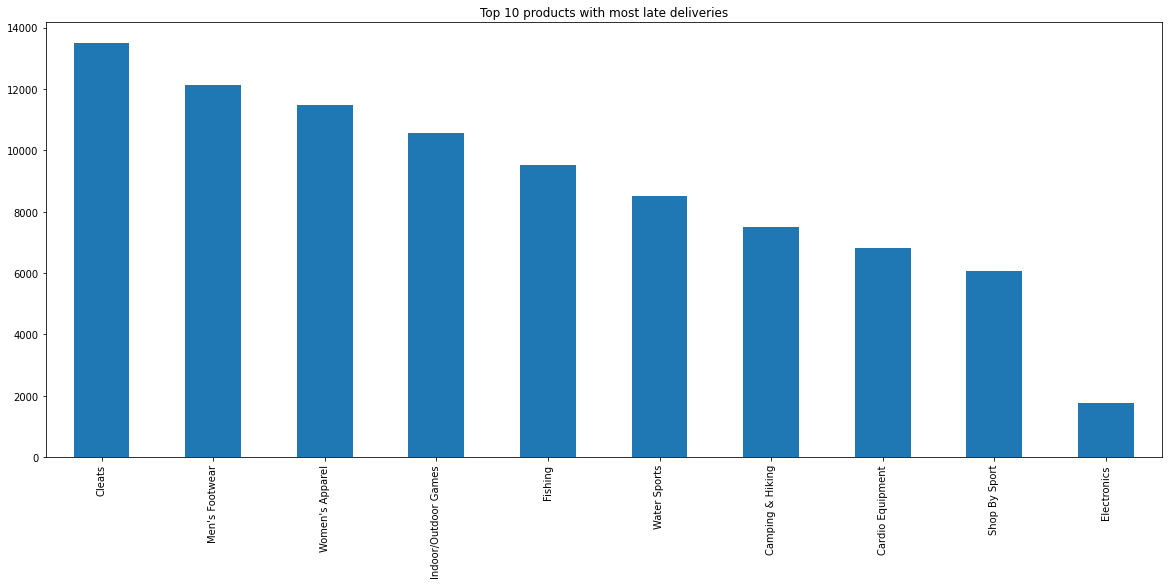

In [99]:
#Filtering columns with late delivery status
late_delivery = data[(data['Delivery Status'] == 'Late delivery')]
#Top 10 products with most late deliveries
late_delivery['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Top 10 products with most late deliveries")

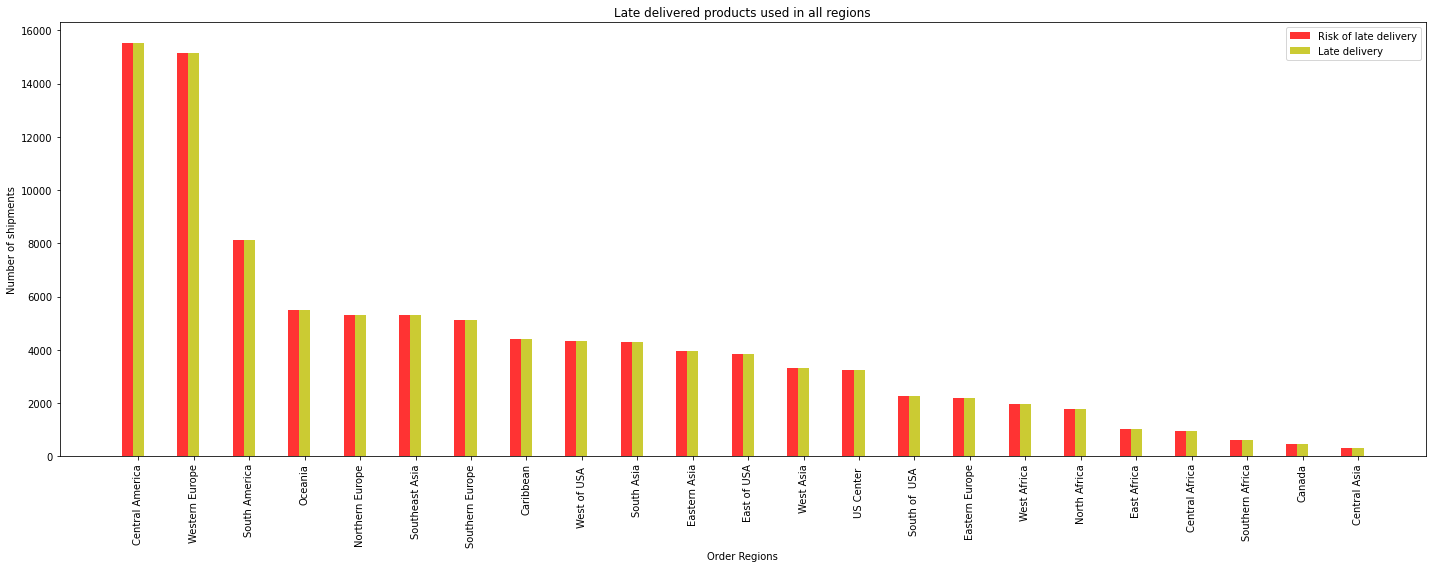

In [100]:
#Filtering orders with late delivery risk
xyz1 = data[(data['Late_delivery_risk'] == 1)]
#Filtering late delivered orders
xyz2 = data[(data['Delivery Status'] == 'Late delivery')]
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
#Index names
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8)) #Figure size
index=np.arange(n_groups)
bar_width=0.2
opacity=0.8
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='r',label='Risk of late delivery')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='y',label='Late delivery')
plt.xlabel('Order Regions')
plt.ylabel('Number of shipments')
plt.title('Late delivered products used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

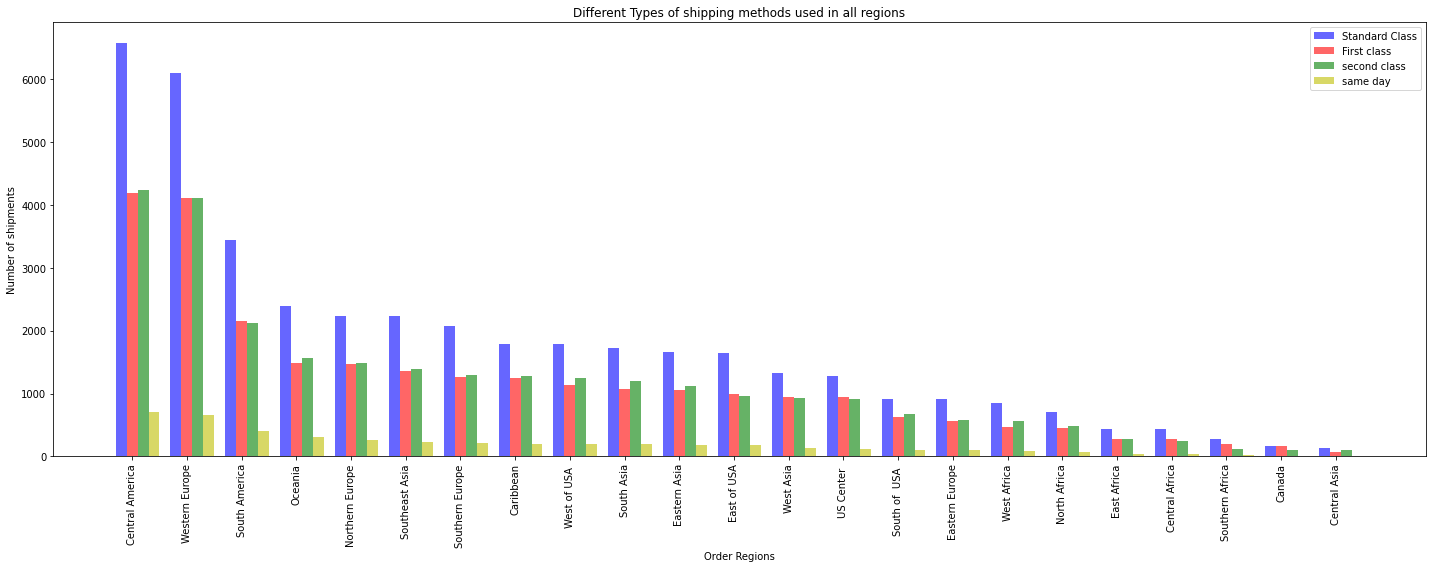

In [101]:
#Filtering late delivery orders with standard class shipping
xyz1 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Standard Class')]
#Filtering late delivery orders with first class shipping
xyz2 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'First Class')]
#Filtering late delivery orders with second class shipping
xyz3 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Second Class')]
#Filtering late delivery orders with same day shipping
xyz4 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Same Day')]
#Counting total values
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
count3=xyz3['Order Region'].value_counts()
count4=xyz4['Order Region'].value_counts()
#Index names
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Standard Class')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='First class')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='second class')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='same day')
plt.xlabel('Order Regions')
plt.ylabel('Number of shipments')
plt.title('Different Types of shipping methods used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

In [102]:
################################################################################################################################

In [103]:
#Calculating total price for which each order
data['TotalPrice'] = data['Order Item Quantity'] * data['Order Item Total']# Multiplying item price * Order quantity


In [104]:
data['order date (DateOrders)'].max() # Calculating when the last order come to check recency

'9/9/2017 9:50'

In [105]:
present = dt.datetime(2017,9,9)
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'])

In [106]:
# Grouping all values into new data frame named customer segmentation
Customer_seg = data.groupby('Order Customer Id').agg({'order date (DateOrders)': lambda x: (present - x.max()).days, 'Order Id': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})
#Changing order dates to int format
Customer_seg['order date (DateOrders)'] = Customer_seg['order date (DateOrders)'].astype(int)
# Renaming columns as R_Value,F_Value,M_Value
Customer_seg.rename(columns={'order date (DateOrders)': 'R_Value', 
                         'Order Id': 'F_Value', 
                         'TotalPrice': 'M_Value'}, inplace=True)
Customer_seg.head()

,R_Value,F_Value,M_Value
Order Customer Id,,,
1,647,1,2362.250061
2,-9,10,2842.700073
3,84,18,6143.760057
4,235,14,4370.629991
5,312,7,2993.790032


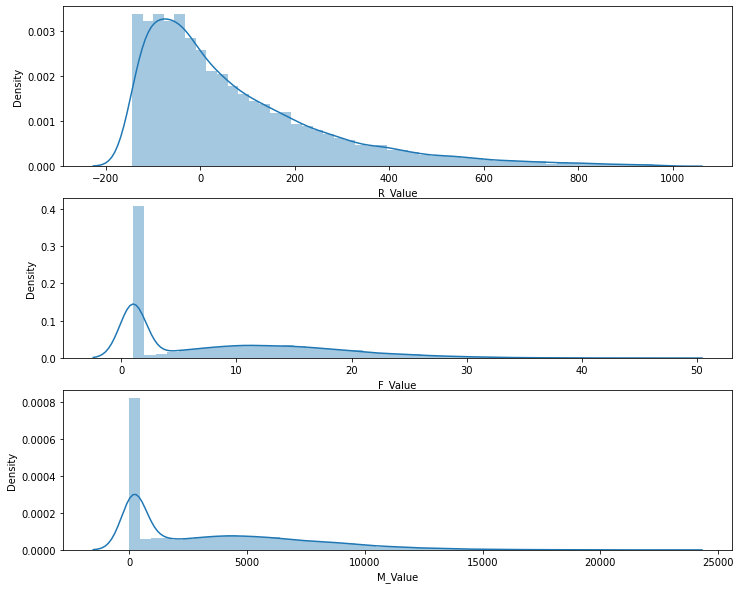

In [107]:
plt.figure(figsize=(12,10)) # Figure size
plt.subplot(3, 1, 1)
sns.distplot(Customer_seg['R_Value'])# Plot distribution of R_Value
plt.subplot(3, 1, 2) 
sns.distplot(Customer_seg['F_Value'])# Plot distribution of F_Value
plt.subplot(3, 1, 3)
sns.distplot(Customer_seg['M_Value'])# Plot distribution of M_Value
plt.show()

In [108]:
quantiles = Customer_seg.quantile(q=[0.25,0.5,0.75]) #Dividing RFM data into four quartiles
quantiles = quantiles.to_dict() 

In [109]:
# R_Score should be minimum so 1st quantile is set as 1.
def R_Score(a,b,c):
    if a <= c[b][0.25]:
        return 1
    elif a <= c[b][0.50]:
        return 2
    elif a <= c[b][0.75]: 
        return 3
    else:
        return 4
# The higher the F_Score,M_Score the better so 1st quantile is set as 4.    
def FM_Score(x,y,z):
    if x <= z[y][0.25]:
        return 4
    elif x <= z[y][0.50]:
        return 3
    elif x <= z[y][0.75]: 
        return 2
    else:
        return 1

In [110]:
# New column for R_Score to indicate numerical score between 1 to 4.
Customer_seg['R_Score'] = Customer_seg['R_Value'].apply(R_Score, args=('R_Value',quantiles))
# New column for F_Score to indicate numerical score between 1 to 4.
Customer_seg['F_Score'] = Customer_seg['F_Value'].apply(FM_Score, args=('F_Value',quantiles))
# New column for M_Score to indicate numerical score between 1 to 4.
Customer_seg['M_Score'] = Customer_seg['M_Value'].apply(FM_Score, args=('M_Value',quantiles))
Customer_seg.head()


,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score
Order Customer Id,,,,,,
1,647,1,2362.250061,4,4,3
2,-9,10,2842.700073,2,2,2
3,84,18,6143.760057,3,1,1
4,235,14,4370.629991,4,2,2
5,312,7,2993.790032,4,3,2


In [111]:
#Adding R,F,M Scores to one new column
Customer_seg['RFM_Score'] = Customer_seg.R_Score.astype(str)+ Customer_seg.F_Score.astype(str) + Customer_seg.M_Score.astype(str)
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score
Order Customer Id,,,,,,,
1,647,1,2362.250061,4,4,3,443
2,-9,10,2842.700073,2,2,2,222
3,84,18,6143.760057,3,1,1,311
4,235,14,4370.629991,4,2,2,422
5,312,7,2993.790032,4,3,2,432


In [112]:
count=Customer_seg['RFM_Score'].unique()
print(count)# Printing all Unique values
len(count)# Total count

['443' '222' '311' '422' '432' '421' '211' '322' '434' '212' '411' '331'
 '412' '433' '321' '423' '333' '312' '221' '223' '332' '233' '232' '323'
 '444' '431' '343' '243' '344' '334' '244' '143' '144']


33

In [113]:
# Calculate RFM_Score
Customer_seg['RFM_Total_Score'] = Customer_seg[['R_Score','F_Score','M_Score']].sum(axis=1)
Customer_seg['RFM_Total_Score'].unique()

array([11,  6,  5,  8,  9,  7,  4, 10, 12], dtype=int64)

In [114]:
# Define rfm_level function
def RFM_Total_Score(df):

    if (df['RFM_Total_Score'] >= 11):# For RFM score with values 11,12
        return 'Champions' 
    elif (df['RFM_Total_Score'] == 10):# For RFM score with value 10
        return 'Loyal Customers' 
    elif (df['RFM_Total_Score'] == 9): # For RFM score with value 9
        return 'Recent Customers'
    elif (df['RFM_Total_Score'] == 8): # For RFM score with value 8
         return 'Promising'
    elif (df['RFM_Total_Score'] == 7): # For RFM score with value 7
        return 'Customers Needing Attention'
    elif (df['RFM_Total_Score'] == 6): # For RFM score with value 6
        return 'Cant lose them'
    elif (df['RFM_Total_Score'] == 5): # For RFM score with value 5
        return 'At Risk'
    else:                               # For RFM score with value less than 5
        
        return 'Lost'
# Create a new variable RFM_Level
Customer_seg['Customer_Segmentation'] =Customer_seg.apply(RFM_Total_Score, axis=1)
# Print the header with top 5 rows to the console
Customer_seg.head()


,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
1,647,1,2362.250061,4,4,3,443,11,Champions
2,-9,10,2842.700073,2,2,2,222,6,Cant lose them
3,84,18,6143.760057,3,1,1,311,5,At Risk
4,235,14,4370.629991,4,2,2,422,8,Promising
5,312,7,2993.790032,4,3,2,432,9,Recent Customers


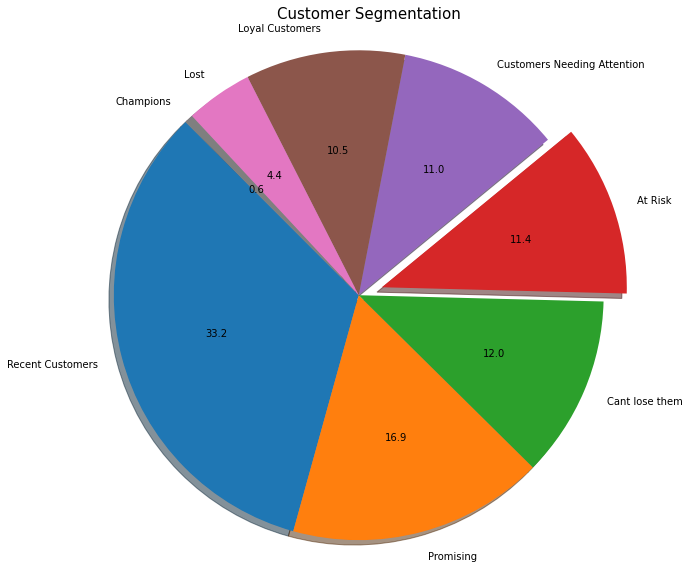

In [115]:
# Calculate average values for each RFM_Level, and return a size of each segment 
Customer_seg['Customer_Segmentation'].value_counts().plot.pie(figsize=(10,10),
                                        startangle=135, explode=(0,0,0,0.1,0,0,0,0),autopct='%.1f',shadow=True)
plt.title("Customer Segmentation",size=15)
plt.ylabel(" ")
plt.axis('equal') 
plt.show()

In [116]:
churned=Customer_seg[(Customer_seg['RFM_Score']=='411')].sort_values('M_Value', ascending=False).head(10)
churned

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
11065,164,41,18641.300091,4,1,1,411,6,Cant lose them
6285,187,37,18287.010097,4,1,1,411,6,Cant lose them
7892,247,29,17620.470196,4,1,1,411,6,Cant lose them
2893,167,24,17536.609842,4,1,1,411,6,Cant lose them
4181,280,29,17333.960094,4,1,1,411,6,Cant lose them
4781,357,31,17048.380088,4,1,1,411,6,Cant lose them
9271,199,35,17044.910217,4,1,1,411,6,Cant lose them
4659,272,27,16973.060024,4,1,1,411,6,Cant lose them
1695,181,33,16916.020176,4,1,1,411,6,Cant lose them


In [117]:
#The R_Score should be low and F_Score, M_Score should be as high as possible
Customer_seg[(Customer_seg['RFM_Score']=='144')|(Customer_seg['RFM_Score']=='143')].sort_values('M_Value', ascending=False).head(10)

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
18101,-107,1,1500.0,1,4,3,143,8,Promising
18083,-106,1,1500.0,1,4,3,143,8,Promising
18047,-106,1,1500.0,1,4,3,143,8,Promising
18065,-106,1,1500.0,1,4,3,143,8,Promising
18119,-107,1,1500.0,1,4,3,143,8,Promising
18046,-106,1,1485.0,1,4,3,143,8,Promising
18100,-107,1,1485.0,1,4,3,143,8,Promising
18118,-107,1,1485.0,1,4,3,143,8,Promising
18064,-106,1,1485.0,1,4,3,143,8,Promising


In [118]:
##############################################################################################################################

In [119]:
train_data=data.copy()

In [120]:
train_data['fraud'] = np.where(train_data['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)
train_data['late_delivery']=np.where(train_data['Delivery Status'] == 'Late delivery', 1, 0)

In [121]:
#Dropping columns with repeated values
train_data.drop(['Delivery Status','Late_delivery_risk','Order Status','order_month_year','order date (DateOrders)'], axis=1, inplace=True)

In [122]:
train_data.dtypes


Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Category Id                        int64
Category Name                     object
Customer City                     object
Customer Country                  object
Customer Id                        int64
Customer Segment                  object
Customer State                    object
Customer Zipcode                 float64
Department Id                      int64
Department Name                   object
Market                            object
Order City                        object
Order Country                     object
Order Customer Id                  int64
Order Id                           int64
Order Item Cardprod Id             int64
Order Item Discount              float64
Order Item Discount Rate         float64
Order Item Id                      int64
Order Item Produ

In [124]:
# create the Labelencoder object
le = preprocessing.LabelEncoder()
#convert the categorical columns into numeric
train_data['Customer Country']  = le.fit_transform(train_data['Customer Country'])
train_data['Market']            = le.fit_transform(train_data['Market'])
train_data['Type']              = le.fit_transform(train_data['Type'])
train_data['Product Name']      = le.fit_transform(train_data['Product Name'])
train_data['Customer Segment']  = le.fit_transform(train_data['Customer Segment'])
train_data['Customer State']    = le.fit_transform(train_data['Customer State'])
train_data['Order Region']      = le.fit_transform(train_data['Order Region'])
train_data['Order City']        = le.fit_transform(train_data['Order City'])
train_data['Category Name']     = le.fit_transform(train_data['Category Name'])
train_data['Customer City']     = le.fit_transform(train_data['Customer City'])
train_data['Department Name']   = le.fit_transform(train_data['Department Name'])
train_data['Order State']       = le.fit_transform(train_data['Order State'])
train_data['Shipping Mode']     = le.fit_transform(train_data['Shipping Mode'])
#train_data['order_week_day']    = le.fit_transform(train_data['order_week_day'])
train_data['Order Country']     = le.fit_transform(train_data['Order Country'])
train_data['Customer Full Name']= le.fit_transform(train_data['Customer Full Name'])

#display the initial records
train_data.head()


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Category Id,Category Name,Customer City,Customer Country,Customer Id,...,Product Price,Shipping Mode,Customer Full Name,order_year,order_month,order_hour,order_week_day,TotalPrice,fraud,late_delivery
0,1,3,4,91.250000,314.640015,73,40,66,1,20755,...,327.75,3,1876,2018,1,22,<bound method inherit_from_data.<locals>.metho...,314.640015,0,0
1,3,5,4,-249.089996,311.359985,73,40,66,1,19492,...,327.75,3,5378,2018,1,12,<bound method inherit_from_data.<locals>.metho...,311.359985,0,1
2,0,4,4,-247.779999,309.720001,73,40,452,0,19491,...,327.75,3,4429,2018,1,12,<bound method inherit_from_data.<locals>.metho...,309.720001,0,0
3,1,3,4,22.860001,304.809998,73,40,285,0,19490,...,327.75,3,12929,2018,1,11,<bound method inherit_from_data.<locals>.metho...,304.809998,0,0
4,2,2,4,134.210007,298.250000,73,40,66,1,19489,...,327.75,3,10638,2018,1,11,<bound method inherit_from_data.<locals>.metho...,298.250000,0,0


In [129]:
train_data=train_data.drop(['order_week_day'],axis=1)

In [130]:
#All columns expect fraud
xf=train_data.loc[:, train_data.columns != 'fraud']
#Only fraud column
yf=train_data['fraud']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
xf_train, xf_test,yf_train,yf_test = train_test_split(xf,yf,test_size = 0.2,random_state = 42)
#All columns expect fraud
xl=train_data.loc[:, train_data.columns != 'late_delivery']
#Only fraud column
yl=train_data['late_delivery']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
xl_train, xl_test,yl_train,yl_test = train_test_split(xl,yl,test_size = 0.2, random_state = 42)

In [131]:
sc = StandardScaler()
xf_train=sc.fit_transform(xf_train)
xf_test=sc.transform(xf_test)
xl_train=sc.fit_transform(xl_train)
xl_test=sc.transform(xl_test)

In [132]:
def classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test):
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)  
    accuracy_f=accuracy_score(yf_pred, yf_test) #Accuracy for fraud detection
    accuracy_l=accuracy_score(yl_pred, yl_test) #Accuracy for predection of late delivery
    recall_f=recall_score(yf_pred, yf_test) #Recall score for  fraud detection
    recall_l=recall_score(yl_pred, yl_test)# Recall score for predection of late delivery
    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery
    f1_f=f1_score(yf_test, yf_pred)#fraud detection
    f1_l=f1_score(yl_test, yl_pred)#predection of late delivery
    print('Model paramters used are :',model_f)
    print('Accuracy of fraud status is        :', (accuracy_f)*100,'%')
    print('Recall score of fraud status is        :', (recall_f)*100,'%')
    print('Conf Matrix of fraud status is        :\n',  (conf_f))
    print('F1 score of fraud status is        :', (f1_f)*100,'%')
    print('Accuracy of late delivery status is:', (accuracy_l)*100,'%')
    print('Recall score of late delivery status is:', (recall_l)*100,'%')
    print('Conf Matrix of late delivery status is: \n',(conf_l))
    print('F1 score of late delivery status is:', (f1_l)*100,'%')

In [133]:
model_f = LogisticRegression(solver='lbfgs',random_state=0) #the classification model
model_l = LogisticRegression(solver='lbfgs',random_state=0) #the classification model
#Giving inputs to the defined function
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

Model paramters used are : LogisticRegression(random_state=0)
Accuracy of fraud status is        : 97.80633724795037 %
Recall score of fraud status is        : 59.66666666666667 %
Conf Matrix of fraud status is        :
 [[35133   121]
 [  671   179]]
F1 score of fraud status is        : 31.130434782608702 %
Accuracy of late delivery status is: 98.84777309993352 %
Recall score of late delivery status is: 97.9419185672587 %
Conf Matrix of late delivery status is: 
 [[15891   416]
 [    0 19797]]
F1 score of late delivery status is: 98.96025993501625 %


In [134]:
model_f = svm.LinearSVC()
model_l = svm.LinearSVC()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

Model paramters used are : LinearSVC()
Accuracy of fraud status is        : 97.75925105251495 %
Recall score of fraud status is        : 56.9023569023569 %
Conf Matrix of fraud status is        :
 [[35126   128]
 [  681   169]]
F1 score of fraud status is        : 29.468177855274625 %
Accuracy of late delivery status is: 98.84777309993352 %
Recall score of late delivery status is: 97.9419185672587 %
Conf Matrix of late delivery status is: 
 [[15891   416]
 [    0 19797]]
F1 score of late delivery status is: 98.96025993501625 %


In [135]:
model_f = RandomForestClassifier()
model_l = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

Model paramters used are : RandomForestClassifier()
Accuracy of fraud status is        : 98.69543540881897 %
Recall score of fraud status is        : 99.22077922077922 %
Conf Matrix of fraud status is        :
 [[35251     3]
 [  468   382]]
F1 score of fraud status is        : 61.86234817813765 %
Accuracy of late delivery status is: 98.83669399512519 %
Recall score of late delivery status is: 97.9225404362665 %
Conf Matrix of late delivery status is: 
 [[15887   420]
 [    0 19797]]
F1 score of late delivery status is: 98.95036737141999 %
